# RAG Retrieval Method Comparison: Bayesian vs. Neural Approaches

This notebook compares two RAG methodologies:

1. **Non-Neural (Sturdy Statistics)**: Hierarchical Bayesian language models
2. **Neural (Dense Embeddings)**: Transformer-based embeddings with FAISS vector search

We evaluate end-to-end RAG performance using Gemini as a generation model (Claude performed poorly in prior analyses), comparing their outputs to golden answers from the DocFinQA dataset.

## Notebook Sections

1. Setup & Configuration
2. Sample Data from DocFinQA
3. Train Sturdy Statistics Indices
4. Retrieval: Both Methods
5. LLM Queries: Gemini
6. Evaluation & Visualization
7. Save Results

---
## 1. Setup & Configuration

In [1]:
# Install required packages (uncomment if needed)
# !pip install sturdy-stats-sdk
# !pip install langchain langchain-community langchain-huggingface
# !pip install faiss-cpu
# !pip install anthropic
# !pip install google-generativeai
# !pip install bert-score
# !pip install pandas matplotlib seaborn pyarrow
# !pip install ijson requests

In [2]:
# Core imports
import json
import os
import random
import time
import uuid
import warnings
from pathlib import Path

import ijson
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
from bert_score import score as bert_score

warnings.filterwarnings("ignore", category=UserWarning)


/Users/christopherstewart/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# =============================================================================
# CONFIGURATION - UPDATE THESE VALUES
# =============================================================================

STURDY_API_KEY = "REDACTED"
ANTHROPIC_API_KEY = "REDACTED"
GEMINI_API_KEY = "REDACTED"

DATA_DIR = "./data"
RESULTS_DIR = "./results"

DOCFINQA_URL = "https://huggingface.co/datasets/kensho/DocFinQA/resolve/main/train.json"
SAMPLE_SIZE = 50
RANDOM_SEED = 42

INDEX_PREFIX = "retrain_smaller_rag_exp__larger"

EMBEDDING_MODEL = "intfloat/e5-small-v2"
CHUNK_SIZE = 1024
CHUNK_OVERLAP = 30
TOP_K_NEURAL = 4

STURDY_LIMIT = 4
STURDY_CONTEXT = 1

GEMINI_MODEL = "gemini-2.5-flash"

BERTSCORE_MODEL = "roberta-large"

Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

PROMPT_TEMPLATE = """# Task
You are a financial QA assistant.
Answer the question using only the information in the context.

# Output format
Return your answer as free text. If it's a number, just output the number (don't wrap in words). Otherwise, output a concise sentence.

# Prediction
Context: {context}
Question: {question}
Answer:"""

print("Setup is complete.")

Setup is complete.


---
## 2. Sample Data from DocFinQA

In [4]:
# Sample data from DocFinQA using reservoir sampling
print("Sampling from DocFinQA Dataset")
print(f"\nURL: {DOCFINQA_URL}")
print(f"Sample size: {SAMPLE_SIZE}")
print(f"Random seed: {RANDOM_SEED}")
print("\nStreaming and sampling (this may take a few minutes)...\n")

random.seed(RANDOM_SEED)
reservoir = []
total_items = 0

with requests.get(DOCFINQA_URL, stream=True) as response:
    response.raise_for_status()
    parser = ijson.items(response.raw, 'item')
    
    for index, item in enumerate(parser):
        total_items = index + 1
        
        if index < SAMPLE_SIZE:
            reservoir.append(item)
        else:
            r_int = random.randint(0, index)
            if r_int < SAMPLE_SIZE:
                reservoir[r_int] = item
        
        if (index + 1) % 500 == 0:
            print(f"  Processed {index + 1} items...")

print(f"\nTotal items in dataset: {total_items}")
print(f"Sampled: {len(reservoir)} items")

Sampling from DocFinQA Dataset

URL: https://huggingface.co/datasets/kensho/DocFinQA/resolve/main/train.json
Sample size: 50
Random seed: 42

Streaming and sampling (this may take a few minutes)...

  Processed 500 items...
  Processed 1000 items...
  Processed 1500 items...
  Processed 2000 items...
  Processed 2500 items...
  Processed 3000 items...
  Processed 3500 items...
  Processed 4000 items...
  Processed 4500 items...
  Processed 5000 items...
  Processed 5500 items...

Total items in dataset: 5735
Sampled: 50 items


In [5]:
samples = []
for row in reservoir:
    samples.append({
        "id": str(uuid.uuid4()),
        "context": row.get('Context', ''),
        "question": row.get('Question', ''),
        "answer": row.get('Answer', '')
    })

df_sample = pd.DataFrame(samples)

print(f"Created DataFrame with {len(df_sample)} samples")
print(f"Columns: {df_sample.columns.tolist()}")
df_sample.head(5)

Created DataFrame with 50 samples
Columns: ['id', 'context', 'question', 'answer']


,id,context,question,answer
0,90e40801-8318-4aee-b6e1-1f601d02a65b,Table\tof\tContents\n\n# UNITED\tSTATES\tSECUR...,what was the percent of the change in the comp...,32.6%
1,a5c83a16-c4bb-49a7-9335-9e2713e04552,# UNITED\tSTATES\n\n# SECURITIES\tAND\tEXCHANG...,what percentage of the revised allocation of n...,10%
2,14be6f59-571e-44c9-8ef8-c0815aae0ba8,QuickLinks\t--\tClick\there\tto\trapidly\tnavi...,what was the average quarterly highs in 2004,8.86
3,07e7bd0b-d110-471c-a4fb-eefd43c4cec8,# Table\tof\tContents\n\n# UNITED\tSTATES\n\n#...,what is the fair value of hologic common stock?,48.2
4,b14ca1ce-9515-44e0-9ee7-54c3b6d1deb2,Table\tof\tContents\n\n# UNITED\tSTATES\n\n# S...,what was the sum of the entergy mississippi 20...,38802


In [6]:
df_sample.to_parquet(f"{DATA_DIR}/docfinqa_sample.parquet", index=False)
df_sample.to_csv(f"{DATA_DIR}/docfinqa_sample.csv", index=False)
df_sample.to_json(f"{DATA_DIR}/docfinqa_sample.json", orient='records', indent=2)

print("Sampled data saved to:")
print(f"  - {DATA_DIR}/docfinqa_sample.parquet")
print(f"  - {DATA_DIR}/docfinqa_sample.csv")
print(f"  - {DATA_DIR}/docfinqa_sample.json")

Sampled data saved to:
  - ./data/docfinqa_sample.parquet
  - ./data/docfinqa_sample.csv
  - ./data/docfinqa_sample.json


In [7]:
print("Sample Preview")
print("="*60)

for i, row in df_sample.head(2).iterrows():
    print(f"\n--- Sample {i+1} ---")
    print(f"ID: {row['id']}")
    print(f"Index name (once trained) will be: {INDEX_PREFIX}_{row['id'][:8]}")
    print(f"Question: {row['question'][:100]}...")
    print(f"Answer: {row['answer']}")

Sample Preview

--- Sample 1 ---
ID: 90e40801-8318-4aee-b6e1-1f601d02a65b
Index name (once trained) will be: retrain_smaller_rag_exp__larger_90e40801
Question: what was the percent of the change in the company 2019s reserve for product warranties in , 2006...
Answer: 32.6%

--- Sample 2 ---
ID: a5c83a16-c4bb-49a7-9335-9e2713e04552
Index name (once trained) will be: retrain_smaller_rag_exp__larger_a5c83a16
Question: what percentage of the revised allocation of net assets acquired is property , plant and equipment?...
Answer: 10%


---
## 3. Train Sturdy Statistics Indices

We create and train a Sturdy Statistics index for each sampled document. Training takes a few minutes for each document ("context").

Documentation: [docs.sturdystatistics.com](https://docs.sturdystatistics.com/reference/index_class.html)

In [8]:

from sturdystats.index import Index
print(f"\nIndex naming pattern: {INDEX_PREFIX}_{{doc_id[:8]}}")
print(f"Number of documents: {len(df_sample)}")

def train_index(row):
    """Train a Sturdy Statistics index model for a single document."""
    index_name = f"{INDEX_PREFIX}_{row['id'][:8]}"
    
    print(f"Training: {index_name}")
    print(f"      Document ID: {row['id']}")
    print(f"      Context length: {len(row['context'])} chars")
    
    # Check that index doesn't already exist BEFORE creating, stop training all indices if so
    existing_indices = Index(name="_check", API_key=STURDY_API_KEY).listIndices(name_filter=index_name)
    assert len(existing_indices) == 0, \
        f"Index '{index_name}' already exists. Delete it first or use a different INDEX_PREFIX."
    
    try:
        start_time = time.time()
        
        index = Index(name=index_name, API_key=STURDY_API_KEY)
        index.upload([{"doc": row['context']}])
        CONTEXT = 0
        index.train(fast=False,
                    regex_paragraph_splitter="donotsplitzzzzuuid",
                    max_paragraph_length=1024, wait=False)
        
        train_time = time.time() - start_time
        
        test_results = index.query(row['question'], limit=1)
        test_success = not test_results.empty
        
        print(f"      ✓ Complete in {train_time:.1f}s (test query: {'passed' if test_success else 'failed'})")
        
        return {
            "doc_id": row['id'],
            "index_name": index_name,
            "status": "success",
            "train_time_sec": round(train_time, 1),
            "test_query_success": test_success
        }
        
    except Exception as e:
        print(f"      ✗ Error: {e}")
        return {
            "doc_id": row['id'],
            "index_name": index_name,
            "status": "error",
            "error": str(e)
        }
# Train all index models
training_log = df_sample.apply(train_index, axis=1).tolist()

# Save training log
df_training_log = pd.DataFrame(training_log)
df_training_log.to_json(f"{RESULTS_DIR}/training_log.json", orient='records', indent=2)

print(f"\n{'='*60}")
print("Training Complete!")
print(f"{'='*60}")
print(f"Successful: {len([x for x in training_log if x['status'] == 'success'])}")
print(f"Failed: {len([x for x in training_log if x['status'] == 'error'])}")
print(f"\nTraining log saved to: {RESULTS_DIR}/training_log.json")


Index naming pattern: retrain_smaller_rag_exp__larger_{doc_id[:8]}
Number of documents: 50
Training: retrain_smaller_rag_exp__larger_90e40801
      Document ID: 90e40801-8318-4aee-b6e1-1f601d02a65b
      Context length: 293782 chars
Uploading data to UNTRAINED index for training.
uploading data to index...
committing changes to index "index_8a028ac8d6dc46309e143299f6bfd9f5"...
      ✓ Complete in 70.3s (test query: passed)
Training: retrain_smaller_rag_exp__larger_a5c83a16
      Document ID: a5c83a16-c4bb-49a7-9335-9e2713e04552
      Context length: 300940 chars
Uploading data to UNTRAINED index for training.
uploading data to index...
committing changes to index "index_c4fa2dbcef9c4550a8c52d1409f62fc9"...
      ✓ Complete in 69.8s (test query: passed)
Training: retrain_smaller_rag_exp__larger_14be6f59
      Document ID: 14be6f59-571e-44c9-8ef8-c0815aae0ba8
      Context length: 378809 chars
Uploading data to UNTRAINED index for training.
uploading data to index...
committing changes 

In [9]:
df_training_log

,doc_id,index_name,status,train_time_sec,test_query_success
0,90e40801-8318-4aee-b6e1-1f601d02a65b,retrain_smaller_rag_exp__larger_90e40801,success,70.3,True
1,a5c83a16-c4bb-49a7-9335-9e2713e04552,retrain_smaller_rag_exp__larger_a5c83a16,success,69.8,True
2,14be6f59-571e-44c9-8ef8-c0815aae0ba8,retrain_smaller_rag_exp__larger_14be6f59,success,85.6,True
3,07e7bd0b-d110-471c-a4fb-eefd43c4cec8,retrain_smaller_rag_exp__larger_07e7bd0b,success,131.8,True
4,b14ca1ce-9515-44e0-9ee7-54c3b6d1deb2,retrain_smaller_rag_exp__larger_b14ca1ce,success,999.5,True
5,f6a0a5b6-8d0e-4486-8453-64c7aceb18e5,retrain_smaller_rag_exp__larger_f6a0a5b6,success,94.0,True
6,922d5d32-e6da-462a-a096-d5f1ad46c044,retrain_smaller_rag_exp__larger_922d5d32,success,66.6,True
7,cdd2b512-e19e-4747-84c0-9bbe0e91ceef,retrain_smaller_rag_exp__larger_cdd2b512,success,111.6,True
8,a33dae5c-a8a9-4ab0-87f7-8e7fb6dd7437,retrain_smaller_rag_exp__larger_a33dae5c,success,122.5,True
9,4073eb63-0adf-4764-b0d3-0ea7dfff659c,retrain_smaller_rag_exp__larger_4073eb63,success,86.3,True


---
## 4. Retrieval: Both Methods

Now we retrieve context from the documents in the sample using both methods:

### Sturdy Statistics (Non-Neural)
- Queries the trained indices by name
- Returns passages based on similarity to the question

### Neural Embeddings (E5 + FAISS)
- Chunks document and creates embeddings on-the-fly
- Uses similarity search to find relevant chunks
- Returns top-4 most similar chunks

In [10]:
from sturdystats.index import Index

def sturdy_retrieve(doc_id: str, question: str, api_key: str, 
                    limit: int = STURDY_LIMIT, context: int = STURDY_CONTEXT) -> str:
    """
    Retrieve relevant passages from a trained Sturdy Statistics index.
    
    Args:
        doc_id: Document ID (used to construct index name)
        question: Search query
        api_key: Sturdy Statistics API key
        limit: Number of results to return (default 4 to match neural)
        context: Number of surrounding sentences to include (default 1)
        
    Returns:
        Retrieved text passages joined together
    """
    # Construct index name using the same names from training to ensure that training and retrieval get the same trained index models
    index_name = f"{INDEX_PREFIX}_{doc_id[:8]}"
    
    try:
        index = Index(name=index_name, API_key=api_key)
        
        results = index.query(
            question, 
            limit=limit,
            context=context,
            # Changing the following two parameters' values doesn't seem to have much effect
            semantic_search_cutoff=0.1,
            semantic_search_weight=0.8
        )
        
        if results.empty:
            return "No results found."
        
        # Join results
        if 'text' in results.columns:
            return " \n ... \n ".join(results.text.tolist())
        else:
            return str(results.iloc[0])
        
    except Exception as e:
        return f"ERROR: {str(e)}"

print("Sturdy Statistics retriever ready.")
print(f"  Index pattern: {INDEX_PREFIX}_{{doc_id[:8]}}")
print(f"  Limit: {STURDY_LIMIT}, Context: {STURDY_CONTEXT}")

Sturdy Statistics retriever ready.
  Index pattern: retrain_smaller_rag_exp__larger_{doc_id[:8]}
  Limit: 4, Context: 1


In [11]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

print(f"Loading embedding model: {EMBEDDING_MODEL}")

# Try GPU, fall back to CPU
try:
    embeddings = HuggingFaceEmbeddings(
        model_name=EMBEDDING_MODEL,
        model_kwargs={'device': 'cuda'},
        encode_kwargs={'normalize_embeddings': True}
    )
    print("  Using GPU for embeddings")
except:
    embeddings = HuggingFaceEmbeddings(
        model_name=EMBEDDING_MODEL,
        model_kwargs={'device': 'cpu'},
        encode_kwargs={'normalize_embeddings': True}
    )
    print("  Using CPU for embeddings")

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP
)

def neural_retrieve(context: str, question: str, top_k: int = TOP_K_NEURAL) -> str:
    """
    Retrieve relevant passages using neural embeddings.
    
    Args:
        context: Full document text
        question: Search query
        top_k: Number of chunks to retrieve
        
    Returns:
        Retrieved text passages joined together
    """
    if not context or pd.isna(context):
        return "ERROR: Empty context"
    
    try:
        docs = text_splitter.create_documents([context])
        
        if not docs:
            return "ERROR: No chunks created"
        
        # Format for E5 model (requires "passage:" prefix)
        for doc in docs:
            doc.page_content = "passage: " + doc.page_content
        
        # Build vector store
        vector_db = FAISS.from_documents(docs, embeddings)
        
        # Format query for E5 model (requires "query:" prefix)
        formatted_query = "query: " + question
        
        # Perform similarity search
        results = vector_db.similarity_search(formatted_query, k=top_k)
        
        # Join retrieved chunks (remove the "passage: " prefix)
        retrieved_text = " \n ... \n ".join([
            res.page_content.replace("passage: ", "") 
            for res in results
        ])
        
        return retrieved_text
        
    except Exception as e:
        return f"ERROR: {str(e)}"

print(f"\nNeural retriever ready.")
print(f"  Chunk size: {CHUNK_SIZE}, Overlap: {CHUNK_OVERLAP}")
print(f"  Top-K: {TOP_K_NEURAL}")

Loading embedding model: intfloat/e5-small-v2
  Using CPU for embeddings

Neural retriever ready.
  Chunk size: 1024, Overlap: 30
  Top-K: 4


In [12]:
print("Running retrieval for all samples...")
print("=" * 60)

retrieval_results = []

for idx, row in df_sample.iterrows():
    print(f"\n[{idx + 1}/{len(df_sample)}] Processing...")
    print(f"  Question: {row['question'][:60]}...")

    print("  → Neural retrieval...")
    neural_context = neural_retrieve(row['context'], row['question'])
    
    print("  → Sturdy retrieval...")
    sturdy_context = sturdy_retrieve(row['id'], row['question'], STURDY_API_KEY)
    
    retrieval_results.append({
        'id': row['id'],
        'question': row['question'],
        'golden_answer': row['answer'],
        'context_length': len(row['context']),
        'neural_retrieved': neural_context,
        'sturdy_retrieved': sturdy_context,
    })
    
    print("  ✓ Done")

df_results = pd.DataFrame(retrieval_results)
print(f"\n{'=' * 60}")
print(f"Retrieval complete for {len(df_results)} samples.")

Running retrieval for all samples...

[1/50] Processing...
  Question: what was the percent of the change in the company 2019s rese...
  → Neural retrieval...
  → Sturdy retrieval...
  ✓ Done

[2/50] Processing...
  Question: what percentage of the revised allocation of net assets acqu...
  → Neural retrieval...
  → Sturdy retrieval...
  ✓ Done

[3/50] Processing...
  Question: what was the average quarterly highs in 2004...
  → Neural retrieval...
  → Sturdy retrieval...
  ✓ Done

[4/50] Processing...
  Question: what is the fair value of hologic common stock?...
  → Neural retrieval...
  → Sturdy retrieval...
  ✓ Done

[5/50] Processing...
  Question: what was the sum of the entergy mississippi 2019s receivable...
  → Neural retrieval...
  → Sturdy retrieval...
  ✓ Done

[6/50] Processing...
  Question: what is the working capital of bwe at the time of the acquis...
  → Neural retrieval...
  → Sturdy retrieval...
  ✓ Done

[7/50] Processing...
  Question: what was the percentage chan

In [13]:
print("Checking for retrieval errors...\n")

sturdy_errors = df_results['sturdy_retrieved'].str.startswith('ERROR').sum()
neural_errors = df_results['neural_retrieved'].str.startswith('ERROR').sum()

print(f"Sturdy retrieval errors: {sturdy_errors}/{len(df_results)}")
print(f"Neural retrieval errors: {neural_errors}/{len(df_results)}")

if sturdy_errors > 0:
    print("\n⚠️  Sturdy errors found:")
    for idx, row in df_results[df_results['sturdy_retrieved'].str.startswith('ERROR')].iterrows():
        print(f"  - {row['id'][:8]}: {row['sturdy_retrieved'][:100]}")

Checking for retrieval errors...

Sturdy retrieval errors: 0/50
Neural retrieval errors: 0/50


In [14]:
# Preview retrieval comparison for first sample
sample_idx = 0
print(f"Sample {sample_idx + 1} Retrieval Comparison")
print("=" * 60)
print(f"\nQuestion: {df_results.iloc[sample_idx]['question']}")
print(f"\nGolden Answer: {df_results.iloc[sample_idx]['golden_answer']}")
print(f"\n{'='*60}")
print("STURDY STATISTICS RETRIEVED:")
print("="*60)
print(df_results.iloc[sample_idx]['sturdy_retrieved'][:1500])
print(f"\n{'='*60}")
print("NEURAL EMBEDDINGS RETRIEVED:")
print("="*60)
print(df_results.iloc[sample_idx]['neural_retrieved'][:1500])

Sample 1 Retrieval Comparison

Question: what was the percent of the change in the company 2019s reserve for product warranties in , 2006

Golden Answer: 32.6%

STURDY STATISTICS RETRIEVED:
	The	Company	has	historically	not	experienced	significant	credit	losses	from	investments	and accounts	receivable.	The	Company	performs	a	regular	review	of	customer	activity	and	associated	credit	risks.

The	Company's	products	require	customized	components	that	currently	are	available	from	a	limited	number	of	sources.	The	Company	obtains	certain	key	components	included	in	its	products from	single	vendors.

Shipments	to	customers	outside	the	United	States	comprised	51%,	43%	and	44%	of	the	Company's	revenue	for	the	years	ended	December	28,	2008,	December	30,	2007	and	December	31,	2006, respectively.	Customers	outside	the	United	States	represented	61%	and	46%	of	the	Company's	net	accounts	receivable	balance	as	of	December	28,	2008	and	December	30,	2007,	respectively.	Sales	to territories	outside	of	the	

In [15]:
# Preview retrieval comparison for second sample
sample_idx = 1
print(f"Sample {sample_idx + 1} Retrieval Comparison")
print("=" * 60)
print(f"\nQuestion: {df_results.iloc[sample_idx]['question']}")
print(f"\nGolden Answer: {df_results.iloc[sample_idx]['golden_answer']}")
print(f"\n{'='*60}")
print("STURDY STATISTICS RETRIEVED:")
print("="*60)
print(df_results.iloc[sample_idx]['sturdy_retrieved'][:1500])
print(f"\n{'='*60}")
print("NEURAL EMBEDDINGS RETRIEVED:")
print("="*60)
print(df_results.iloc[sample_idx]['neural_retrieved'][:1500])

Sample 2 Retrieval Comparison

Question: what percentage of the revised allocation of net assets acquired is property , plant and equipment?

Golden Answer: 10%

STURDY STATISTICS RETRIEVED:
	At December	31,	2018,	PCA's	historical	plans,	which	comprised	$384.3	million	of	the	total	fair	value	of	plan	assets,	targeted	50%	invested	in	equities,	49%	invested	in fixed	income	securities,	and	1%	in	other,	whereas	the	Boise	plans,	which	comprised	$488.9	million	of	the	total	fair	value	of	plan	assets,	targeted	54%	invested	in	fixed income	securities,	44%	invested	in	equities,	and	2%	in	other.	Our	retirement	committee	reviews	the	investment	allocations	for	reasonableness	at	a	minimum,	semi- annually.

Investment	securities,	in	general,	are	exposed	to	various	risks,	such	as	interest	rate,	credit,	and	overall	market	volatility	risk,	all	of	which	are	subject	to	change. Due	to	the	level	of	risk	associated	with	some	investment	securities,	it	is	reasonably	possible	that	changes	in	the	values	of	invest

In [16]:
# Preview retrieval comparison for third sample
sample_idx = 2
print(f"Sample {sample_idx + 1} Retrieval Comparison")
print("=" * 60)
print(f"\nQuestion: {df_results.iloc[sample_idx]['question']}")
print(f"\nGolden Answer: {df_results.iloc[sample_idx]['golden_answer']}")
print(f"\n{'='*60}")
print("STURDY STATISTICS RETRIEVED:")
print("="*60)
print(df_results.iloc[sample_idx]['sturdy_retrieved'][:1500])
print(f"\n{'='*60}")
print("NEURAL EMBEDDINGS RETRIEVED:")
print("="*60)
print(df_results.iloc[sample_idx]['neural_retrieved'][:1500])

Sample 3 Retrieval Comparison

Question: what was the average quarterly highs in 2004

Golden Answer: 8.86

STURDY STATISTICS RETRIEVED:
	The	rights	of	the	holders	of	common	stock	will	be	subject	to,	and	may	be	adversely	affected	by,	the	rights	of	the	holders	of	any	class	or	series of	preferred	stock	that	may	be	issued	in	the	future.	As	a	result,	stockholders	or	other	parties	may	find	it	more	difficult	to	remove	or	replace	our	current	management.

# OUR	STOCK	PRICE	MAY	FLUCTUATE	BASED	ON	FACTORS	BEYOND	OUR	CONTROL.

								Market	prices	for	securities	of	companies	such	as	Vertex	are	highly	volatile.	Within	the	twelve	months	ended	December	31,	2005,	our	common	stock	traded between	$8.61	and	$29.24	per	share.	The	market	for	our	stock,	like	that	of	other	companies	in	the	biotechnology	field,	has	from	time	to	time	experienced	significant price	and	volume	fluctuations	that	are	unrelated	to	our	operating	performance.	The	future	market	price	of	our	securities	could	be	significantly	and	adver

---
## 5. LLM Queries: Gemini

Now we query both LLMs with the retrieved context to generate answers.

In [17]:
# Initialize Gemini client
import google.generativeai as genai

genai.configure(api_key=GEMINI_API_KEY)
gemini_model = genai.GenerativeModel(GEMINI_MODEL)

def query_gemini(prompt: str) -> str:
    """Generate a response from Gemini."""
    try:
        response = gemini_model.generate_content(prompt)
        return response.text.strip()
    except Exception as e:
        return f"ERROR: {str(e)}"

print(f"Gemini client ready ({GEMINI_MODEL}).")

/Users/christopherstewart/miniconda3/lib/python3.10/site-packages/google/api_core/_python_version_support.py:275: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


Gemini client ready (gemini-2.5-flash).


/var/folders/yz/b85wg_255898k2wxf6v6tbfc0000gn/T/ipykernel_24472/2578583462.py:2: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  import google.generativeai as genai


In [18]:
# Query Gemini with both retrieval methods
print("Querying LLM with retrieved context...")
print("=" * 60)

responses = {
    'response_sturdy_gemini': [],
    'response_neural_gemini': [],
}

for idx, row in df_results.iterrows():
    print(f"\n[{idx + 1}/{len(df_results)}] Querying LLM...")
    
    # Build prompts
    prompt_sturdy = PROMPT_TEMPLATE.format(
        context=row['sturdy_retrieved'],
        question=row['question']
    )
    prompt_neural = PROMPT_TEMPLATE.format(
        context=row['neural_retrieved'],
        question=row['question']
    )
    

    print("  → Sturdy + Gemini...")
    responses['response_sturdy_gemini'].append(query_gemini(prompt_sturdy))
    time.sleep(0.5)  # Rate limiting
    
    print("  → Neural + Gemini...")
    responses['response_neural_gemini'].append(query_gemini(prompt_neural))
    time.sleep(0.5)
    
    print("  ✓ Done")

# Add responses to DataFrame
for col, values in responses.items():
    df_results[col] = values

print(f"\n{'=' * 60}")
print("Retrieval for both methods is complete.")

Querying LLM with retrieved context...

[1/50] Querying LLM...
  → Sturdy + Gemini...
  → Neural + Gemini...
  ✓ Done

[2/50] Querying LLM...
  → Sturdy + Gemini...
  → Neural + Gemini...
  ✓ Done

[3/50] Querying LLM...
  → Sturdy + Gemini...
  → Neural + Gemini...
  ✓ Done

[4/50] Querying LLM...
  → Sturdy + Gemini...
  → Neural + Gemini...
  ✓ Done

[5/50] Querying LLM...
  → Sturdy + Gemini...
  → Neural + Gemini...
  ✓ Done

[6/50] Querying LLM...
  → Sturdy + Gemini...
  → Neural + Gemini...
  ✓ Done

[7/50] Querying LLM...
  → Sturdy + Gemini...
  → Neural + Gemini...
  ✓ Done

[8/50] Querying LLM...
  → Sturdy + Gemini...
  → Neural + Gemini...
  ✓ Done

[9/50] Querying LLM...
  → Sturdy + Gemini...
  → Neural + Gemini...
  ✓ Done

[10/50] Querying LLM...
  → Sturdy + Gemini...
  → Neural + Gemini...
  ✓ Done

[11/50] Querying LLM...
  → Sturdy + Gemini...
  → Neural + Gemini...
  ✓ Done

[12/50] Querying LLM...
  → Sturdy + Gemini...
  → Neural + Gemini...
  ✓ Done

[13/50] Q

In [19]:
# Preview LLM responses for first question
sample_idx = 0
print(f"Sample {sample_idx + 1} LLM Response Comparison")
print("=" * 60)
print(f"\nQuestion: {df_results.iloc[sample_idx]['question']}")
print(f"\nGolden Answer: {df_results.iloc[sample_idx]['golden_answer']}")
print(f"\n--- Sturdy + Gemini ---")
print(df_results.iloc[sample_idx]['response_sturdy_gemini'])
print(f"\n--- Neural + Gemini ---")
print(df_results.iloc[sample_idx]['response_neural_gemini'])

Sample 1 LLM Response Comparison

Question: what was the percent of the change in the company 2019s reserve for product warranties in , 2006

Golden Answer: 32.6%

--- Sturdy + Gemini ---
The context does not provide the percentage change in the company's reserve for product warranties in 2006.

--- Neural + Gemini ---
32.62%


In [20]:
# Preview LLM responses for second question
sample_idx = 1
print(f"Sample {sample_idx + 1} LLM Response Comparison")
print("=" * 60)
print(f"\nQuestion: {df_results.iloc[sample_idx]['question']}")
print(f"\nGolden Answer: {df_results.iloc[sample_idx]['golden_answer']}")
print(f"\n--- Sturdy + Gemini ---")
print(df_results.iloc[sample_idx]['response_sturdy_gemini'])
print(f"\n--- Neural + Gemini ---")
print(df_results.iloc[sample_idx]['response_neural_gemini'])

Sample 2 LLM Response Comparison

Question: what percentage of the revised allocation of net assets acquired is property , plant and equipment?

Golden Answer: 10%

--- Sturdy + Gemini ---
The provided context does not contain information on the percentage of property, plant and equipment in the revised allocation of net assets acquired.

--- Neural + Gemini ---
9.75


---
## 6. Look at Sturdy vs. neural embedding retrieval

In [21]:
# Display final results table
display_cols = ['golden_answer', 'response_sturdy_gemini', 'response_neural_gemini']
df_results[display_cols]

,golden_answer,response_sturdy_gemini,response_neural_gemini
0,32.6%,The context does not provide the percentage ch...,32.62%
1,10%,The provided context does not contain informat...,9.75
2,8.86,11.36,The information is not available in the provid...
3,48.2,The context does not provide a specific fair v...,"$3,742,800"
4,38802,The context does not provide the sum of Enterg...,The information to answer this question is not...
5,184.5,The context does not provide information on th...,The information is not in the context.
6,12%,11.85%,11.85%
7,42,The provided context does not contain informat...,The context does not provide information about...
8,0.18,0.18,0.18
9,1.43%,The context does not provide information about...,The provided context does not contain informat...


---
### 6.1. Count the number of times that Sturdy vs. Neural retrieval retrieved relevant context
---

In [24]:
no_info_keywords = ["context does not", "information is not", "not available", "not contain"]

sturdy_no_info = df_results['response_sturdy_gemini'].str.contains('|'.join(no_info_keywords), case=False, na=False).sum()
sturdy_has_num = (df_results['response_sturdy_gemini'].str.contains(r'\d', na=False) & ~df_results['response_sturdy_gemini'].str.contains('|'.join(no_info_keywords), case=False, na=False)).sum()

neural_no_info = df_results['response_neural_gemini'].str.contains('|'.join(no_info_keywords), case=False, na=False).sum()
neural_has_num = (df_results['response_neural_gemini'].str.contains(r'\d', na=False) & ~df_results['response_neural_gemini'].str.contains('|'.join(no_info_keywords), case=False, na=False)).sum()

print(f"Sturdy Gemini: {sturdy_has_num} numbers, {sturdy_no_info} no-info strings")
print(f"Neural Gemini: {neural_has_num} numbers, {neural_no_info} no-info strings")

Sturdy Gemini: 25 numbers, 23 no-info strings
Neural Gemini: 30 numbers, 18 no-info strings


---
### 6.2. Calculate semantic similarity between golden answers and Sturdy vs. Neural retrieval
---

Calculating BEM scores for Sturdy Gemini...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.91s/it]


computing greedy matching.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.52it/s]


done in 9.85 seconds, 5.08 sentences/sec
Calculating BEM scores for Neural Gemini...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.98s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 149.59it/s]


done in 3.96 seconds, 12.62 sentences/sec

BEM SCORE SUMMARY STATISTICS
Sturdy Gemini Average: 0.8832
Neural Gemini Average: 0.8872
Difference: 0.0040


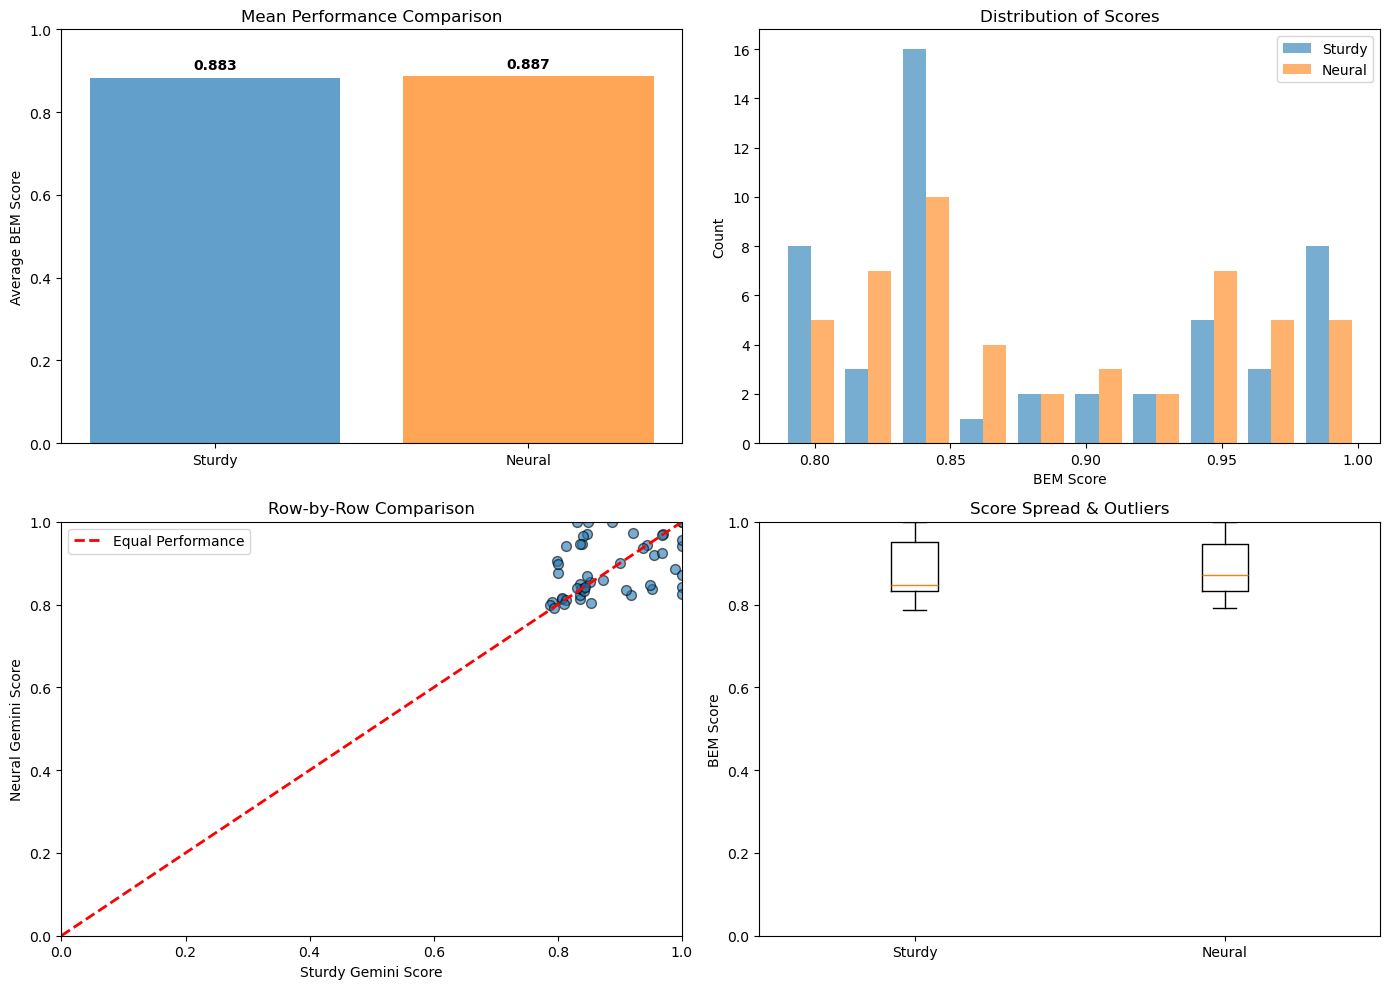

In [26]:
from bert_score import score

def calculate_bem(predictions, references):
    """
    Calculates BERTScore (Semantic F1).
    # Ensure inputs are lists of strings
    predictions = [str(p) for p in predictions]
    references = [str(r) for r in references]
    
    P, R, F1 = score(predictions, references, lang="en", model_type="roberta-large", verbose=True)
    return F1.numpy()

print("Calculating BEM scores for Sturdy Gemini...")
df_results['llm_bem_score_sturdy'] = calculate_bem(
    df_results['response_sturdy_gemini'], 
    df_results['golden_answer']
)

print("Calculating BEM scores for Neural Gemini...")
df_results['llm_bem_score_neural'] = calculate_bem(
    df_results['response_neural_gemini'], 
    df_results['golden_answer']
)

avg_sturdy = df_results['llm_bem_score_sturdy'].mean()
avg_neural = df_results['llm_bem_score_neural'].mean()

print("\n" + "="*40)
print("BEM SCORE SUMMARY STATISTICS")
print("="*40)
print(f"Sturdy Gemini Average: {avg_sturdy:.4f}")
print(f"Neural Gemini Average: {avg_neural:.4f}")
print(f"Difference: {avg_neural - avg_sturdy:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].bar(['Sturdy', 'Neural'], [avg_sturdy, avg_neural], color=['#1f77b4', '#ff7f0e'], alpha=0.7)
axes[0,0].set_ylabel('Average BEM Score')
axes[0,0].set_title('Mean Performance Comparison')
axes[0,0].set_ylim([0, 1])
for i, v in enumerate([avg_sturdy, avg_neural]):
    axes[0,0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

axes[0,1].hist([df_results['llm_bem_score_sturdy'], df_results['llm_bem_score_neural']], 
              bins=10, label=['Sturdy', 'Neural'], color=['#1f77b4', '#ff7f0e'], alpha=0.6)
axes[0,1].set_xlabel('BEM Score')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Distribution of Scores')
axes[0,1].legend()

axes[1,0].scatter(df_results['llm_bem_score_sturdy'], df_results['llm_bem_score_neural'], 
                alpha=0.6, s=50, edgecolor='black')
axes[1,0].plot([0,1], [0,1], 'r--', lw=2, label='Equal Performance')
axes[1,0].set_xlabel('Sturdy Gemini Score')
axes[1,0].set_ylabel('Neural Gemini Score')
axes[1,0].set_title('Row-by-Row Comparison')
axes[1,0].set_xlim([0,1])
axes[1,0].set_ylim([0,1])
axes[1,0].legend()

axes[1,1].boxplot([df_results['llm_bem_score_sturdy'], df_results['llm_bem_score_neural']])
axes[1,1].set_xticklabels(['Sturdy', 'Neural'])
axes[1,1].set_ylabel('BEM Score')
axes[1,1].set_title('Score Spread & Outliers')
axes[1,1].set_ylim([0,1])

plt.tight_layout()
plt.show()